## Model Training and Development

This Kaggle competition requires that submissions be made by running code and creating an output file from a Kaggle notebook.
I started by running a copy of the recommended tutorial notebook on Kaggle (https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial/notebook).

I let the notebook run to completion in an interactive session and tried to submit the result. At that point I learned that the run had taken 569 minutes, using a TPU, and that a maximum of 300 minutes run time was allowed for submission. I noted that the model had trained for 25 epochs. My second run was for 11 epochs, but again it ran too long at 307 minutes. My third run with 10 epochs ran in 300 minutes, and I was able to submit the result. This run produced a Kaggle score of 78.87916.

I then investigated some of the other public notebooks for this competition, looking for improvement suggestions, including this one: https://www.kaggle.com/code/victorsullivan/i-m-something-of-a-painter-myself/notebook .
I noted that the tutorial notebook used a batch size of one, and that many of the public notebooks were using a batch size of 32. Also the tutorial notebook was using tf.data.Dataset.zip to combine a sequence of 300 Monet images with a sequence of 7038 photos, and then training for a fixed number of epochs as in the following block of code.

In [ ]:
cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=25
)

Zipping the two data sets as above means that the training data was always the 300 Monet images and only the first 300 photos, repeated for every epoch. To use repeating data sets instead, I borrowed the following blocks of code from the VictorSullivan notebook:

In [ ]:
BATCH_SIZE = 32

def get_gan_dataset(monet_files, photo_files, augment=None, repeat=True, shuffle=True, batch_size=1):

    monet_ds = load_dataset(monet_files)
    photo_ds = load_dataset(photo_files)
    
    if augment:
        monet_ds = monet_ds.map(augment, num_parallel_calls=AUTOTUNE)
        photo_ds = photo_ds.map(augment, num_parallel_calls=AUTOTUNE)

    if repeat:
        monet_ds = monet_ds.repeat()
        photo_ds = photo_ds.repeat()
        
#     if shuffle:
#         monet_ds = monet_ds.shuffle(2048)
#         photo_ds = photo_ds.shuffle(2048)
        
    monet_ds = monet_ds.batch(batch_size, drop_remainder=True)
    photo_ds = photo_ds.batch(batch_size, drop_remainder=True)
#     monet_ds = monet_ds.cache()
#     photo_ds = photo_ds.cache()
    monet_ds = monet_ds.prefetch(AUTOTUNE)
    photo_ds = photo_ds.prefetch(AUTOTUNE)
    
    gan_ds = tf.data.Dataset.zip((monet_ds, photo_ds))
    
    return gan_ds

final_data_set = get_gan_dataset(MONET_FILENAMES, PHOTO_FILENAMES, augment=None, 
                                 repeat=True, shuffle=True, batch_size=BATCH_SIZE)

Using the final_data_set for training this way means that the Monet images and photos will each be repeated indefinitely as required. When using a repeating data set this way, the step_per_epoch parameter is needed to determine how many batches are processesed for each epoch of training -- as in this example:

In [ ]:
cycle_gan_model.fit(final_data_set, epochs=28, steps_per_epoch=1490)

With these changes, I ran the model for 30 epochs of 1500 batches each, and got an improved Kaggle score of 40.66223 and a run time of 137 minutes.

I think the improvement in score resulted from 2 factors:
    
* using the full set of photos instead of just the first 300
* effectively a lot more training time was availble because a batch size of 32 makes much more efficent use of the TPU versus a batch size of one.

Next we tried to improve the score by varying the the number of epochs or the total number of batches used for training. With the CycleGAN models it is hard to know how much training will give the best result. With a typical supervised learning problem we could use a validation loss score and early stopping to train just the right number of iterations and avoid overfitting. But with GAN models, the discriminators and generators are both improving as long as the losses stay relatively balanced. There is not an objective way to know when to stop based on the losses. I tried varying the length of training of this same model for a number of runs. A copy of the notebook for these runs is here: https://github.com/albert-kepner/Week5_DL_CycleGAN/blob/master/monet-cyclegan-tutorialV34.ipynb

In [2]:
import pandas as pd
df = pd.read_excel('./kaggle_scores_01.xlsx')
display(df)

,Version Label,Epochs,Steps per Epoch,Training Batches,Kaggle Score
0,V5,30,1500,45000,40.66223
1,V7,40,1500,60000,41.00751
2,V11,34,1500,51000,42.23765
3,V12,28,1500,42000,38.89318
4,V14,26,1500,39000,45.92713
5,V15,29,1500,43500,50.34030
6,V17,27,1500,40500,41.37489
7,V18,28,1500,42000,38.36144
8,V19,28,1480,41440,40.81393
9,V20,28,1510,42280,40.34160


<AxesSubplot:title={'center':'Kaggle Score versus number of Training batches'}, xlabel='Training Batches', ylabel='Kaggle Score'>

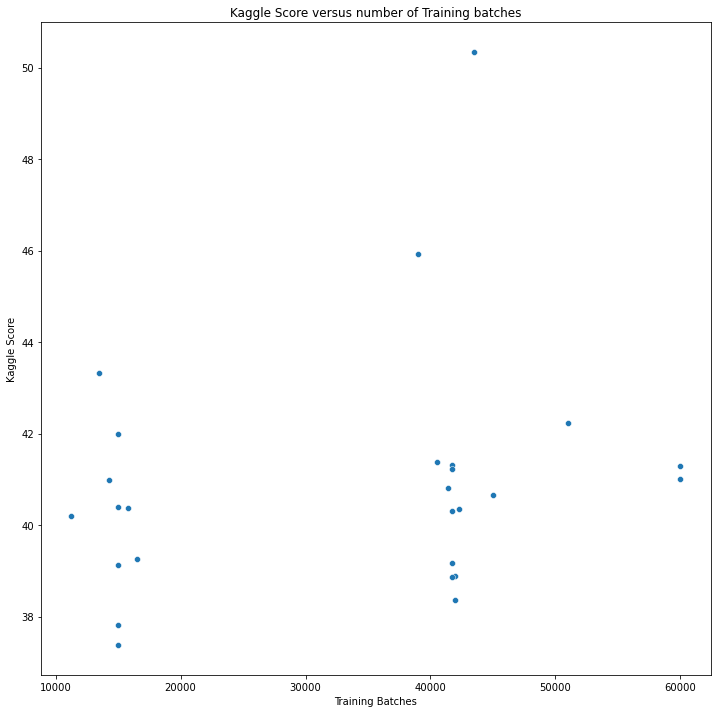

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,12))
plt.title("Kaggle Score versus number of Training batches")
sns.scatterplot(x=df['Training Batches'], y=df['Kaggle Score'])


We were hoping that there would be an obvious correlation between how long the model was trained and the resulting score. However it appears that random variation in both the training and the image generation models is the dominant effect. The best Kaggle score 37.37 was obtained with 15,000 training batches but repeated runs of this length produced similar results to runs of about 42,000 batches. For comparison, the best score currently on the leaderboard is 31.53 .

One thing we tried was creating a plot of the losses over the range of training epochs for both generators and both discriminators. Run V33 of the model was run for 80 epochs of 750 steps each. The average losses per epoch are plotted in this excerpt from the notebook: https://github.com/albert-kepner/Week5_DL_CycleGAN/blob/master/PlotLossesV33.ipynb . The plots are reproduced below. The Photo Descriminator Loss appears to be stable over time after the first few epochs. The Monet Discriminator loss generally decreases over time. We think this is evidence that since there are only 300 Monet images, the Monet Discriminator tends to memorize the real Monet images as training proceeds. As the Monet Discriminator improves over time, the losses for the Monet Generator rise over time, as can be seen in the 2nd plot.

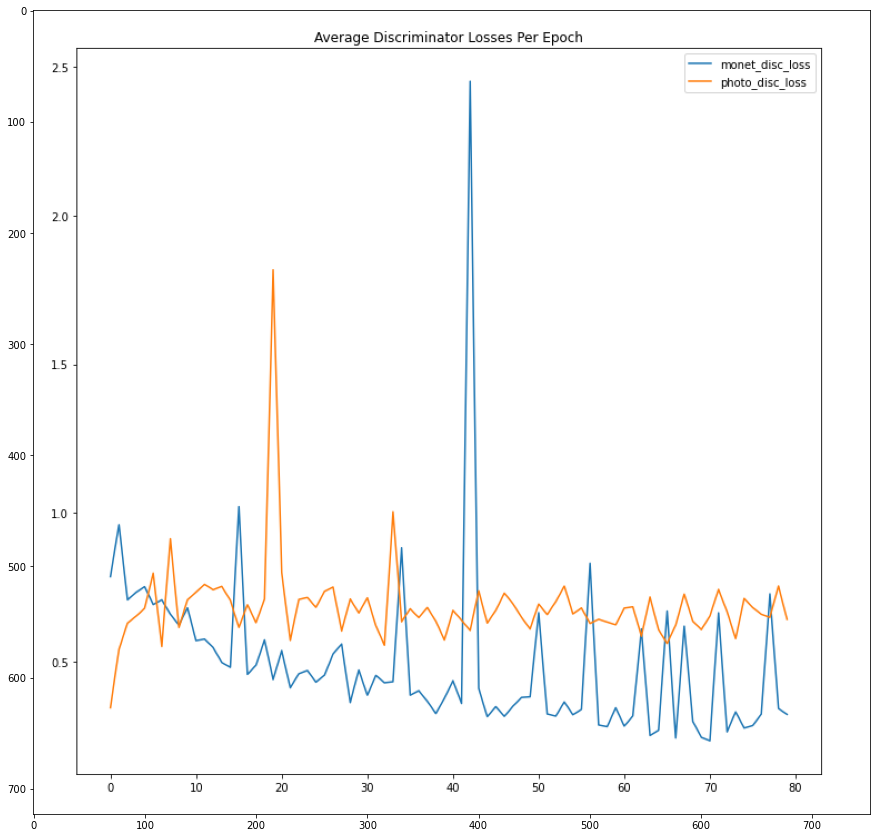

In [8]:
import matplotlib.image as img
import matplotlib.pyplot as plt
image = img.imread("AverageDiscriminatorLossesPerEpoch.PNG")
plt.figure(figsize=(15,15))
plt.imshow(image)

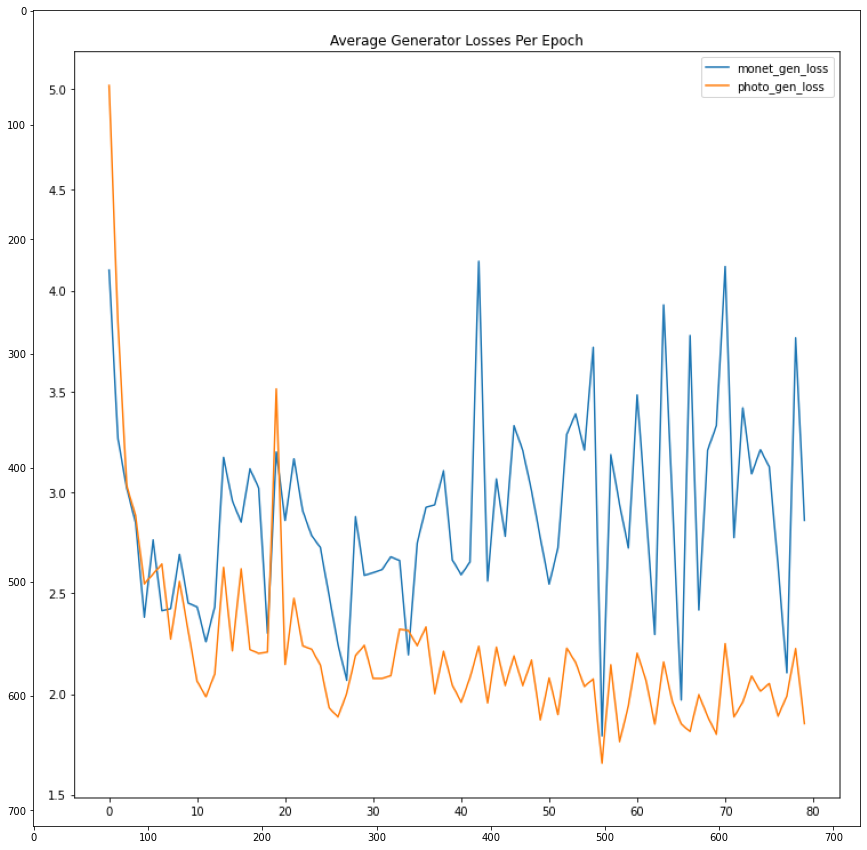

In [9]:
image = img.imread("AverageGeneratorLossesPerEpoch.PNG")
plt.figure(figsize=(15,15))
plt.imshow(image)

This link shows sample generated Monet images from our best scoring model: https://github.com/albert-kepner/Week5_DL_CycleGAN/blob/master/VisualizeV34.ipynb